importing required packages

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
from PIL import ImageFile
from PIL import Image


paths n labels

In [2]:
infra = glob("/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Damaged_Infrastructure/Infrastructure/*.png")

In [3]:
Ufire = glob("/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Fire_Disaster/Urban_Fire/*.png")

In [4]:
Wfire = glob("/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Fire_Disaster/Wild_Fire/*.png")

In [5]:
Hdanger = glob("/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/*.png")

In [6]:
land_slides = glob("/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Land_Disaster/Land_Slide/*.png")

In [7]:
dfX = []
dfX.extend(infra)
print(len(dfX))
dfX.extend(Ufire)
print(len(dfX))
dfX.extend(Wfire)
print(len(dfX))
dfX.extend(Hdanger)
print(len(dfX))
dfX.extend(land_slides)
print(len(dfX))
dfY = ["infra_diast"]*len(infra)
print(len(dfY))
dfY.extend(["urban_fire"]*len(Ufire))
print(len(dfY))
dfY.extend(["wild_fire"]*len(Wfire))
print(len(dfY))
dfY.extend(["human_danger"]*len(Hdanger))
print(len(dfY))
dfY.extend(["land_slides"]*len(land_slides))
print(len(dfY))


1418
1837
2351
2592
3048
1418
1837
2351
2592
3048


In [8]:
len(dfX),len(dfY)

(3048, 3048)

In [9]:
df = pd.DataFrame({"img_path":dfX,"label":dfY})

In [10]:
del(dfX)
del(dfY)

In [11]:
df.head()

,img_path,label
0,/kaggle/input/disaster-images-dataset/Comprehe...,infra_diast
1,/kaggle/input/disaster-images-dataset/Comprehe...,infra_diast
2,/kaggle/input/disaster-images-dataset/Comprehe...,infra_diast
3,/kaggle/input/disaster-images-dataset/Comprehe...,infra_diast
4,/kaggle/input/disaster-images-dataset/Comprehe...,infra_diast


In [12]:
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import preprocess_input, decode_predictions

2024-02-20 05:21:55.162112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 05:21:55.162213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 05:21:55.303133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


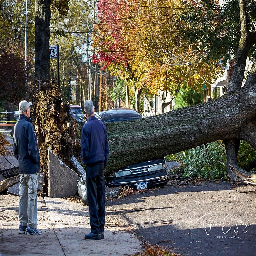

In [13]:
keras.utils.load_img(df["img_path"][0],target_size=(256, 256))


In [14]:
def prep(dir):
    if os.path.isfile(dir):
        try:
            img = keras.utils.load_img(dir, target_size=(300, 300))
            x = keras.utils.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            return x
        except (OSError, Exception) as e:
            print('Problematic file:', dir, 'Error:', e)


In [15]:
imgArrays = df["img_path"].copy()

In [16]:
imgArrays = imgArrays.apply(prep)

Problematic file: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Damaged_Infrastructure/Infrastructure/05_01_0261.png Error: image file is truncated (0 bytes not processed)
Problematic file: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png Error: cannot identify image file <_io.BytesIO object at 0x7beefdde7ce0>


In [17]:
df[df["img_path"]=="/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Human_Damage/02_0069.png"],df[df["img_path"]=="/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Damaged_Infrastructure/Infrastructure/05_01_0261.png"]

(                                               img_path         label
 2524  /kaggle/input/disaster-images-dataset/Comprehe...  human_danger,
                                                img_path        label
 1278  /kaggle/input/disaster-images-dataset/Comprehe...  infra_diast)

In [18]:
imgArrays = imgArrays.drop(2524)
imgArrays = imgArrays.drop(1278)

In [19]:
l = []
for i in imgArrays:
    l.append(i.reshape(300,300,3))
del(imgArrays)

In [20]:
imgArrays = np.array(l)

In [21]:
del(l)

In [22]:
df = df.drop(2524)
df = df.drop(1278)

In [23]:
df["label"].unique()

array(['infra_diast', 'urban_fire', 'wild_fire', 'human_danger',
       'land_slides'], dtype=object)

In [24]:
y = df["label"].copy()
y = y.replace({'infra_diast':0, 'urban_fire':1, 'wild_fire':2, 'human_danger':3,'land_slides':4})
y = to_categorical(y)

/tmp/ipykernel_26/2650534468.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'infra_diast':0, 'urban_fire':1, 'wild_fire':2, 'human_danger':3,'land_slides':4})


In [25]:
xtra,xtes,ytra,ytes = train_test_split(imgArrays, y, test_size=0.2, random_state=42)

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

In [27]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

In [29]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit(
    np.asarray(xtra),
    np.asarray(ytra),
    epochs=15,
    validation_split=0.2
)

Epoch 1/15


I0000 00:00:1708406587.432220      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 [==============================] - 20s 207ms/step - loss: 0.6928 - accuracy: 0.8049 - val_loss: 0.3665 - val_accuracy: 0.8668
Epoch 2/15
61/61 [==============================] - 8s 124ms/step - loss: 0.2400 - accuracy: 0.9107 - val_loss: 0.3727 - val_accuracy: 0.8873
Epoch 3/15
61/61 [==============================] - 8s 125ms/step - loss: 0.1467 - accuracy: 0.9487 - val_loss: 0.3155 - val_accuracy: 0.8955
Epoch 4/15
61/61 [==============================] - 8s 124ms/step - loss: 0.1037 - accuracy: 0.9656 - val_loss: 0.3308 - val_accuracy: 0.8852
Epoch 5/15
61/61 [==============================] - 8s 124ms/step - loss: 0.0715 - accuracy: 0.9774 - val_loss: 0.3737 - val_accuracy: 0.8873
Epoch 6/15
61/61 [==============================] - 8s 124ms/step - loss: 0.0532 - accuracy: 0.9846 - val_loss: 0.3692 - val_accuracy: 0.9016
Epoch 7/15
61/61 [==============================] - 8s 124ms/step - loss: 0.0330 - accuracy: 0.9908 - val_loss: 0.4247 - val_accuracy: 0.9037
Epoch 8/15
61/61

In [31]:
model.evaluate(xtes,ytes)

20/20 [==============================] - 3s 132ms/step - loss: 0.5718 - accuracy: 0.8738


[0.5718351006507874, 0.8737704753875732]